#Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing, model_selection, metrics
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import re
from IPython.display import display
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

#Setting Seed

In [2]:
np.random.seed(2020)

#Loading data

In [3]:
import glob
import zipfile
import pandas as pd

for zip_file in glob.glob("/content/kenzen_data_challenge.zip"):
    zf = zipfile.ZipFile(zip_file)
    dfs = [pd.read_csv(zf.open(f)) for f in zf.namelist()]
    df = pd.concat(dfs,ignore_index=True)

In [4]:
print ("The data file has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " rows")

The data file has 33 columns and 2822175 rows


There are 33 columns and 2822175 rows in the combined data for all 15 users with 2 trails each.

In [5]:
df.columns = df.columns.str.replace(' ', '')

In [6]:
df.head(5)

,userId,DateTime,signalQ1,signalQ2,heartRate,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,ambientTemp110,Flag,Tc,PatchId,SubjectId,Trial,Age,Sex,MenstrualPhase,Height,Weight,TrialType,medicalQuestion1,medicalQuestion2,medicalQuestion3,medicalQuestion4,medicalQuestion5,medicalQuestion6,medicalQuestion7,medicalQuestion8,medicalQuestion9,medicalQuestion10,medicalQuestion11
0,314,2020-10-09 12:27:41,0,9,NaN,123.02,112,NaN,NaN,NaN,NaN,NaN,NaN,31C9,TC1047,Part 2A,22,Female,luteal,175.0,63.0,Continuous,No,No,No,No,No,No,No,No,Yes,Yes,"Yes, >6 months ago"
1,314,2020-10-09 12:27:42,0,11,NaN,123.02,110,NaN,NaN,NaN,NaN,NaN,NaN,31C9,TC1047,Part 2A,22,Female,luteal,175.0,63.0,Continuous,No,No,No,No,No,No,No,No,Yes,Yes,"Yes, >6 months ago"
2,314,2020-10-09 12:27:43,0,11,NaN,123.02,110,NaN,NaN,NaN,NaN,NaN,NaN,31C9,TC1047,Part 2A,22,Female,luteal,175.0,63.0,Continuous,No,No,No,No,No,No,No,No,Yes,Yes,"Yes, >6 months ago"
3,314,2020-10-09 12:27:44,0,13,NaN,123.02,106,NaN,NaN,NaN,NaN,NaN,NaN,31C9,TC1047,Part 2A,22,Female,luteal,175.0,63.0,Continuous,No,No,No,No,No,No,No,No,Yes,Yes,"Yes, >6 months ago"
4,314,2020-10-09 12:27:45,0,15,NaN,123.02,102,22.14,27.83,57.3,29.69,NaN,NaN,31C9,TC1047,Part 2A,22,Female,luteal,175.0,63.0,Continuous,No,No,No,No,No,No,No,No,Yes,Yes,"Yes, >6 months ago"


Created a feature called "Activity Flag", 1 if there is an activity else 0.

In [7]:
df['activity_flag']=np.where(df.Flag.isnull(), 0,1)

In [8]:
df.activity_flag.value_counts()

0    2821925
1        250
Name: activity_flag, dtype: int64

In [9]:
df.MenstrualPhase.value_counts()

luteal                                                                                                                 651606
follicular                                                                                                             367992
irregular                                                                                                              128484
Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods.      73277
Name: MenstrualPhase, dtype: int64

Created a feature called "Menstrual Flag", type of menstrual if there is a menstrual phase else Male.

In [10]:
df['menstrual_flag']=np.where(df.MenstrualPhase.isnull(), 'male',df['MenstrualPhase'])

In [11]:
df.menstrual_flag.value_counts()

male                                                                                                                   1600816
luteal                                                                                                                  651606
follicular                                                                                                              367992
irregular                                                                                                               128484
Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods.       73277
Name: menstrual_flag, dtype: int64

In [ ]:
df.columns

Index(['userId', 'DateTime', 'signalQ1', 'signalQ2', 'heartRate',
       'heartRateAvg', 'stepRate', 'skinRH109', 'skinTemp109', 'ambientRH110',
       'ambientTemp110', 'Flag', 'Tc', 'PatchId', 'SubjectId', 'Trial', 'Age',
       'Sex', 'MenstrualPhase', 'Height', 'Weight', 'TrialType',
       'medicalQuestion1', 'medicalQuestion2', 'medicalQuestion3',
       'medicalQuestion4', 'medicalQuestion5', 'medicalQuestion6',
       'medicalQuestion7', 'medicalQuestion8', 'medicalQuestion9',
       'medicalQuestion10', 'medicalQuestion11', 'activity_flag',
       'menstrual_flag'],
      dtype='object')

Dropped Signal Q2 which is another version of Signal q1, and keeping Signal q1.

Dropping Heart-rate and keeping avg heart rate

Dropping Trail type and medical questions

In [12]:
df=df.drop(columns=[ 'signalQ2', 'heartRate','Flag','TrialType','MenstrualPhase',
       'medicalQuestion1', 'medicalQuestion2', 'medicalQuestion3',
       'medicalQuestion4', 'medicalQuestion5', 'medicalQuestion6',
       'medicalQuestion7', 'medicalQuestion8', 'medicalQuestion9',
       'medicalQuestion10', 'medicalQuestion11'],axis=1)

#Missing Values
1. Core temperature has the most number of missing values (2813242), as it has been collected for every 5 mins (once in every 300 instances).

2. SkinRH109, Skintemp 109, Ambient RH 110, Ambient temp 110 has missing 2202112 times, since they have been collected once in every 5 seconds.

3. Heartrate Average - 26314 missing values


In [13]:
#Missing Values
df.isna().sum()

userId                  0
DateTime                0
signalQ1                0
heartRateAvg        26314
stepRate                0
skinRH109         2202112
skinTemp109       2202112
ambientRH110      2202112
ambientTemp110    2202112
Tc                2813242
PatchId                 0
SubjectId               0
Trial                   0
Age                     0
Sex                     0
Height                  0
Weight                  0
activity_flag           0
menstrual_flag          0
dtype: int64

Creating a list of distinct user id and trail

In [14]:
trail_id=df.Trial.unique()
user_id=df.userId.unique()

# Imputing Missing values:
The most important and difficult part is handling missing values.

Pandas interpolate() function is basically used to fill NA values in the dataframe or series. But, this is a very powerful function to fill the missing values. It uses various interpolation technique to fill the missing values rather than hard-coding the value.

The use of using interpolate rather than filling missing values by mean or median.
For example: we have the data like this [1,NA,4,NA,100], fill NA with mean.
We will get [1,35,4,35,100]. In series we hardly get 35 in between 1 and 4.

If we use interpolate method, we will get [ 1, 2.5,4,54,100]. This is fairly resonable.

As we are having series data, I have used interpolate method to fill NA values.

For example:
In skinRH109, there are 4 values missing between 2 non null values. I imputed the missing values using interpolate method to fill those missing values.
Similarly I have done the same for Hearrate Average, Skintemp 109, Ambient RH 110, Ambient temp 110 and Tc.

"you may need to remove the first hour of data as it could take time for the pill to travel down into the GI tract to accurately measure core temp"

We have record for each second, so for one hour we have 3600 data points.
I have removed first 3600 data points for each user and for each trail.

In [15]:
final=pd.DataFrame()
for user in list(user_id):
  x=df[df['userId']==user]
  for trail in list(trail_id):
    y=x[x['Trial']==trail]
    y['heartRateAvg']=y['heartRateAvg'].interpolate()
    y['stepRate']=y['stepRate'].interpolate()
    y['skinRH109']=y['skinRH109'].interpolate()
    y['skinTemp109']=y['skinTemp109'].interpolate()
    y['ambientRH110']=y['ambientRH110'].interpolate()
    y['ambientTemp110']=y['ambientTemp110'].interpolate()
    y['Tc']=y['Tc'].interpolate()
    z = y.iloc[3601:]
    #print(user, trail)

    final=pd.concat([final,z])

In [ ]:
final.head(5)

,userId,DateTime,signalQ1,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,ambientTemp110,Tc,PatchId,SubjectId,Trial,Age,Sex,Height,Weight,activity_flag,menstrual_flag
3601,314,2020-10-09 13:27:42,0,81.14,0,23.2700,31.954,57.466,33.260,36.819834,31C9,TC1047,Part 2A,22,Female,175.0,63.0,0,luteal
3602,314,2020-10-09 13:27:43,0,81.14,0,23.2600,31.952,57.468,33.260,36.819801,31C9,TC1047,Part 2A,22,Female,175.0,63.0,0,luteal
3603,314,2020-10-09 13:27:44,0,81.15,0,23.2500,31.950,57.470,33.260,36.819767,31C9,TC1047,Part 2A,22,Female,175.0,63.0,0,luteal
3604,314,2020-10-09 13:27:45,0,81.15,0,23.3025,31.950,57.460,33.265,36.819734,31C9,TC1047,Part 2A,22,Female,175.0,63.0,0,luteal
3605,314,2020-10-09 13:27:46,0,81.15,0,23.3550,31.950,57.450,33.270,36.819701,31C9,TC1047,Part 2A,22,Female,175.0,63.0,0,luteal


Converting Datatime data type from object to Data time.

In [16]:
final['DateTime']=pd.to_datetime(final['DateTime'])

# Removing Temperature less than 36 *c

In [17]:
final=final[final['Tc']>=36]

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717746 entries, 3601 to 2822174
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   userId          int64         
 1   DateTime        datetime64[ns]
 2   signalQ1        int64         
 3   heartRateAvg    float64       
 4   stepRate        int64         
 5   skinRH109       float64       
 6   skinTemp109     float64       
 7   ambientRH110    float64       
 8   ambientTemp110  float64       
 9   Tc              float64       
 10  PatchId         object        
 11  SubjectId       object        
 12  Trial           object        
 13  Age             int64         
 14  Sex             object        
 15  Height          float64       
 16  Weight          float64       
 17  activity_flag   int64         
 18  menstrual_flag  object        
dtypes: datetime64[ns](1), float64(8), int64(5), object(5)
memory usage: 414.7+ MB


In [ ]:
print ("The data file has " + str(final.shape[1]) + " columns and " + str(final.shape[0]) + " rows")

The data file has 19 columns and 2717746 rows


Analysing how Male and Female are differing for various features.

In [ ]:
final.groupby('Sex').mean()

,userId,signalQ1,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,ambientTemp110,Tc,Age,Height,Weight,activity_flag
Sex,,,,,,,,,,,,,
Female,244.246738,0.017979,74.982910,18.572926,38.696670,32.298287,64.839743,33.185468,37.065928,23.579392,170.068776,70.927199,0.000100
Male,244.945783,0.007391,65.506944,18.735442,35.884855,31.813074,64.299933,32.827304,36.850858,31.870997,175.392346,81.048966,0.000075


Some Insights:

Average heartrate for a female is 74.98 and 65.50 for male.

ShinRh 109 for female is 38.69 and 35.88 for male.

Average TC for female is 37.06 and 36.85 for male.

In [ ]:
final.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,2717746.0,244.598004,36.233146,173.00,222.000,235.000,276.000000,314.00
signalQ1,2717746.0,0.012659,0.111796,0.00,0.000,0.000,0.000000,1.00
heartRateAvg,2717746.0,70.221284,20.196225,36.11,55.690,67.270,81.490000,204.75
stepRate,2717746.0,18.654590,40.190945,0.00,0.000,0.000,0.000000,270.00
skinRH109,2717746.0,37.283747,8.449349,16.48,31.340,36.350,41.420000,85.36
skinTemp109,2717746.0,32.054469,2.424446,14.00,30.750,32.345,33.722500,38.94
ambientRH110,2717746.0,64.568491,10.773595,36.32,57.452,61.535,68.960000,100.00
ambientTemp110,2717746.0,33.005492,2.086469,14.81,32.132,33.330,34.330000,37.87
Tc,2717746.0,36.957856,0.453022,36.00,36.620,36.970,37.263067,41.20
Age,2717746.0,27.745883,7.041830,19.00,23.000,26.000,28.000000,45.00


Age ranges between 19 and 45.

Height ranges 151cm to 192

weight ranges between 55kgs and 117 kgs

# Core Temperature Distribustion:
As seen below, the core temperature is not Normally distributed.

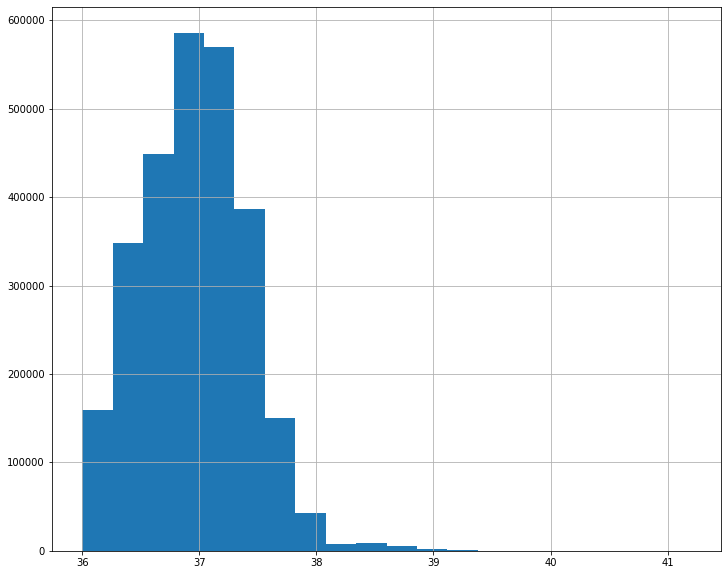

In [ ]:
final.Tc.hist(bins = 20 , figsize= (12,10))

# Finding Outliers

Box Plot to check for outliers.

There are lot of values beyond Q4.

Text(0.5, 1.0, 'Core Temperature distribution')

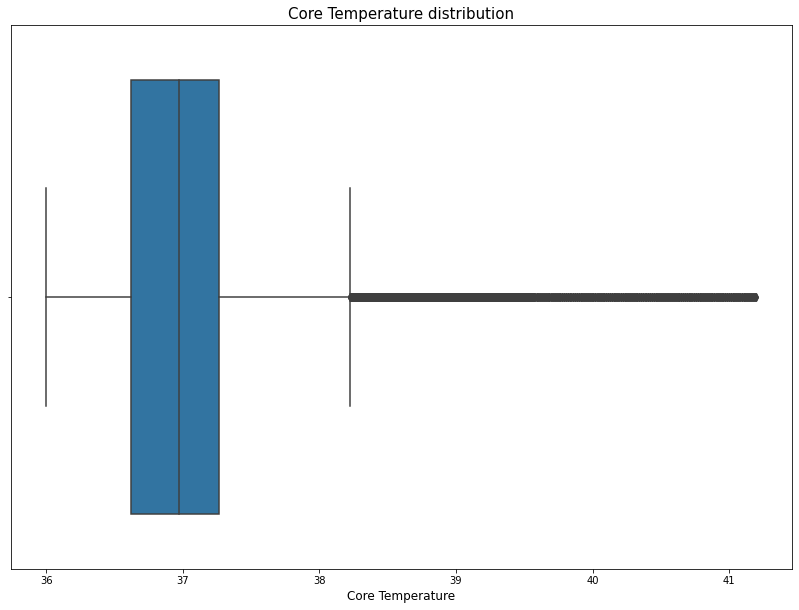

In [ ]:
# boxplot appliances
plt.figure(figsize=(14,10))
sns.boxplot(x="Tc", data=final)
plt.xlabel('Core Temperature', fontsize=12)
plt.title("Core Temperature distribution", fontsize=15)

In [ ]:
#Outliers
Q1 = final['Tc'].quantile(0.25)
Q3 = final['Tc'].quantile(0.75)
IQR = Q3 - Q1
print("The Inter Quartile Range is: ",IQR)

The Inter Quartile Range is:  0.6430666666666696


In [ ]:
Lower_Bound=(Q1 - 1.5 * IQR)
Upper_Bound=(Q3 + 1.5 * IQR)
print('Temperature Lower Bound is:',Lower_Bound)
print('Temperature Upper Bound is:',Upper_Bound)

Temperature Lower Bound is: 35.65539999999999
Temperature Upper Bound is: 38.22766666666667


Since the temperature is not normally distributed, I have used IQR method to remove Outliers.

Removed values beyond upper bound

In [ ]:
#Removing Outliers
#final_df=final[final['Tc']<=Upper_Bound]

In [ ]:
#print ("The data file has " + str(final_df.shape[1]) + " columns and " + str(final_df.shape[0]) + " rows")

The data file has 19 columns and 2695300 rows


Distribution of all features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0afdf02eb8>,
      dtype=object)

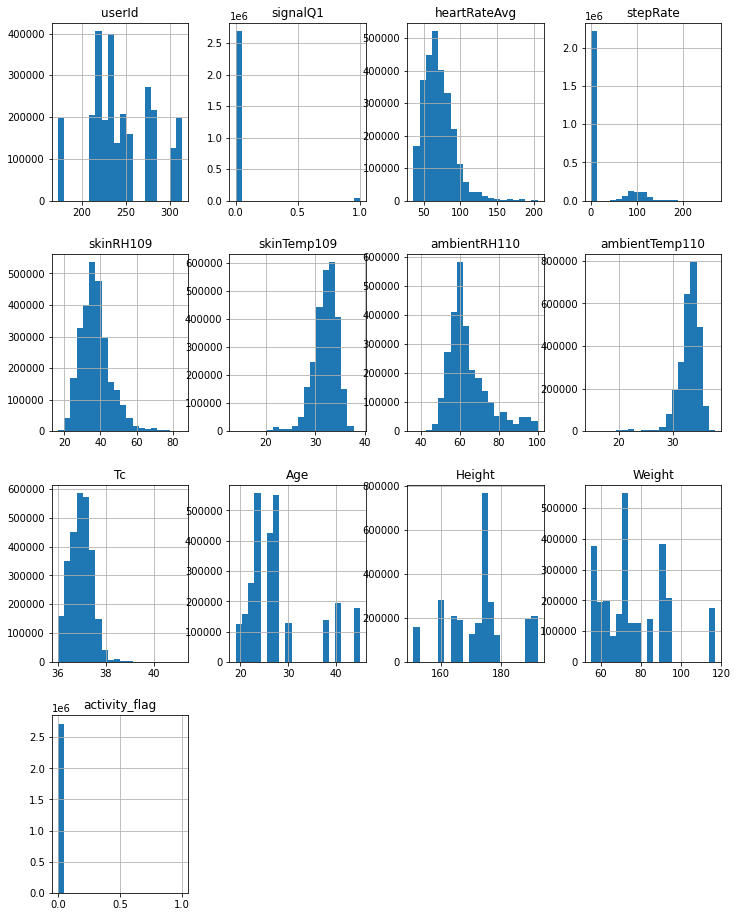

In [ ]:
final.hist(bins = 20 , figsize= (12,16))

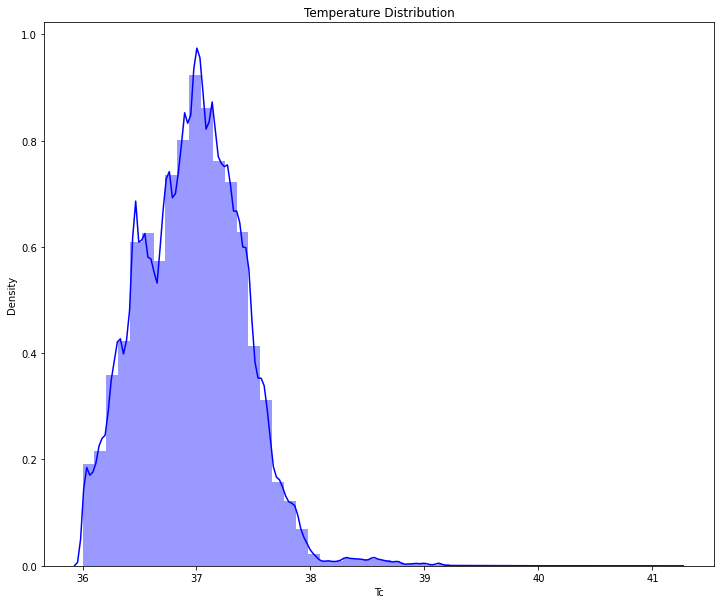

In [ ]:
plt.figure(figsize=(12,10))
plt.title('Temperature Distribution')
sns.distplot(final['Tc'],color='blue');

In [18]:
#Creating Hour column
final['hour'] = final.DateTime.dt.hour

In [ ]:
final.columns

Index(['userId', 'DateTime', 'signalQ1', 'heartRateAvg', 'stepRate',
       'skinRH109', 'skinTemp109', 'ambientRH110', 'ambientTemp110', 'Tc',
       'PatchId', 'SubjectId', 'Trial', 'Age', 'Sex', 'Height', 'Weight',
       'activity_flag', 'menstrual_flag', 'hour'],
      dtype='object')

In [19]:
#Removing unnecessary columns:
final=final.drop(columns=['userId','DateTime','PatchId', 'SubjectId', 'Trial'],axis=1)

In [ ]:
final.signalQ1.value_counts()

0    2683343
1      34403
Name: signalQ1, dtype: int64

In [ ]:
def hourly(x,df):
    return df.groupby('hour')[x].mean()

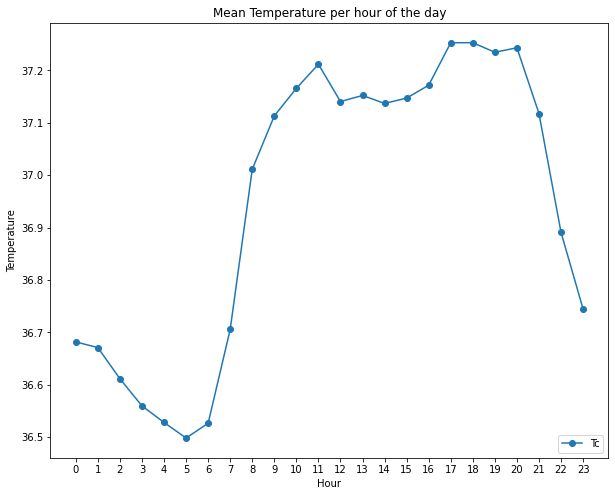

In [ ]:
x=hourly('Tc',final_df).plot(figsize=(10,8),marker='o')
x.legend(loc='lower right')
plt.xlabel('Hour')
ticks = list(range(0, 24, 1))
plt.ylabel('Temperature')
plt.title('Mean Temperature per hour of the day')

plt.xticks(ticks);

Checking mean teamperature for good and bad signals for each hour of the day

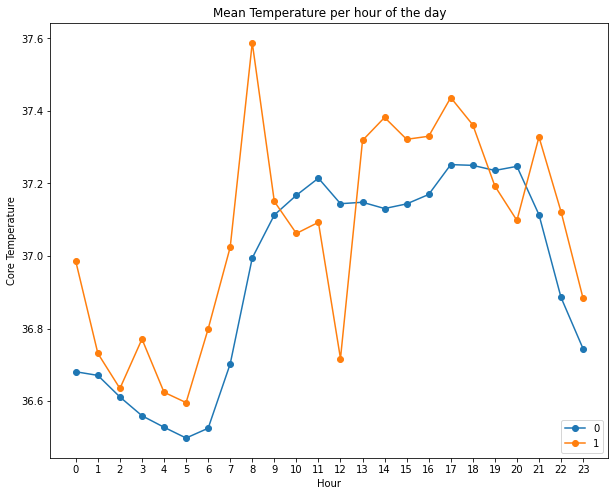

In [ ]:
for signal in [0,1]:

  x=hourly('Tc',final_df[final_df['signalQ1']==signal]).plot(label=signal,figsize=(10,8),marker='o')
  x.legend(loc='lower right')
  plt.xlabel('Hour')
  ticks = list(range(0, 24, 1))
  plt.ylabel('Core Temperature')
  plt.title('Mean Temperature per hour of the day')

  plt.xticks(ticks);

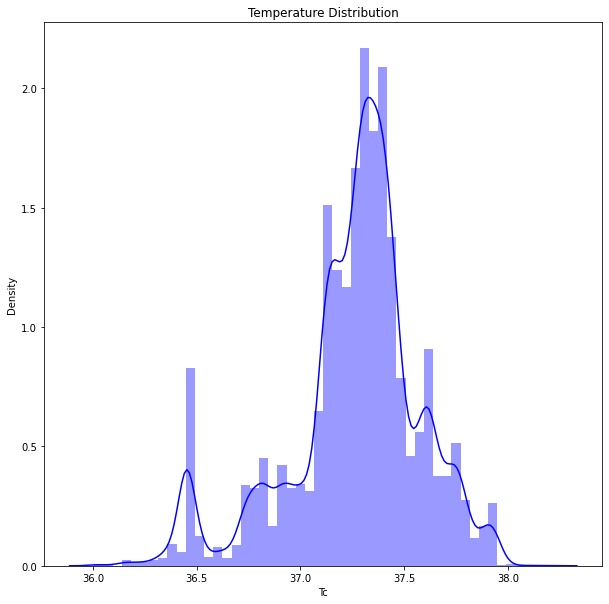

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Temperature Distribution')
bad_signal=final_df[final_df['signalQ1']==1]
sns.distplot(bad_signal['Tc'],color='blue');

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2717746 entries, 3601 to 2822174
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   signalQ1        int64  
 1   heartRateAvg    float64
 2   stepRate        int64  
 3   skinRH109       float64
 4   skinTemp109     float64
 5   ambientRH110    float64
 6   ambientTemp110  float64
 7   Tc              float64
 8   Age             int64  
 9   Sex             object 
 10  Height          float64
 11  Weight          float64
 12  activity_flag   int64  
 13  menstrual_flag  object 
 14  hour            int64  
dtypes: float64(8), int64(5), object(2)
memory usage: 331.8+ MB


In [20]:
#Changing some features to Categorical
final['signalQ1']=final.signalQ1.astype('category')
final['activity_flag']=final.activity_flag.astype('category')

In [21]:
categorical= final.select_dtypes(include=['object', 'bool','category']).columns
categorical

Index(['signalQ1', 'Sex', 'activity_flag', 'menstrual_flag'], dtype='object')

In [22]:
for col in categorical:
    print(np.unique(final[col]))

[0 1]
['Female' 'Male']
[0 1]
['Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods. '
 'follicular' 'irregular' 'luteal' 'male']


In [23]:
# transforming categorical columns
final = pd.get_dummies(final, columns=categorical)

In [ ]:
final.head()

,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,ambientTemp110,Tc,Age,Height,Weight,hour,signalQ1_0,signalQ1_1,Sex_Female,Sex_Male,activity_flag_0,activity_flag_1,menstrual_flag_Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods.,menstrual_flag_follicular,menstrual_flag_irregular,menstrual_flag_luteal,menstrual_flag_male
3601,81.14,0,23.2700,31.954,57.466,33.260,36.819834,22,175.0,63.0,13,1,0,1,0,1,0,0,0,0,1,0
3602,81.14,0,23.2600,31.952,57.468,33.260,36.819801,22,175.0,63.0,13,1,0,1,0,1,0,0,0,0,1,0
3603,81.15,0,23.2500,31.950,57.470,33.260,36.819767,22,175.0,63.0,13,1,0,1,0,1,0,0,0,0,1,0
3604,81.15,0,23.3025,31.950,57.460,33.265,36.819734,22,175.0,63.0,13,1,0,1,0,1,0,0,0,0,1,0
3605,81.15,0,23.3550,31.950,57.450,33.270,36.819701,22,175.0,63.0,13,1,0,1,0,1,0,0,0,0,1,0


In [ ]:
final.corr()

,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,ambientTemp110,Tc,Age,Height,Weight,hour,signalQ1_0,signalQ1_1,Sex_Female,Sex_Male,activity_flag_0,activity_flag_1,menstrual_flag_Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods.,menstrual_flag_follicular,menstrual_flag_irregular,menstrual_flag_luteal,menstrual_flag_male
heartRateAvg,1.000000,0.411438,-0.267795,-0.245731,0.105807,-0.153193,0.563350,-0.037560,-0.106908,0.094687,0.334916,-0.114358,0.114358,0.234595,-0.234595,-0.004484,0.004484,0.118205,0.110342,0.069622,0.162144,-0.280449
stepRate,0.411438,1.000000,-0.185216,-0.211548,0.108423,-0.131244,0.294424,0.018521,-0.017949,-0.024593,0.163825,-0.088697,0.088697,-0.002022,0.002022,-0.004732,0.004732,-0.028383,0.013382,-0.023342,-0.002437,0.011994
skinRH109,-0.267795,-0.185216,1.000000,0.181836,0.225395,0.106262,-0.292778,-0.182115,-0.092330,-0.063137,-0.276442,0.017887,-0.017887,0.166390,-0.166390,0.001494,-0.001494,0.047803,0.087538,0.086291,-0.054722,-0.064524
skinTemp109,-0.245731,-0.211548,0.181836,1.000000,-0.030542,0.952679,-0.221473,0.100150,-0.089509,-0.012441,-0.168374,0.192513,-0.192513,0.100066,-0.100066,0.005360,-0.005360,0.037939,0.038702,0.066977,-0.022312,-0.047636
ambientRH110,0.105807,0.108423,0.225395,-0.030542,1.000000,0.044917,0.102398,-0.183948,-0.158658,-0.186387,-0.030319,0.062880,-0.062880,0.025052,-0.025052,-0.000149,0.000149,-0.138281,0.131760,0.064450,-0.116473,0.027889
ambientTemp110,-0.153193,-0.131244,0.106262,0.952679,0.044917,1.000000,-0.122130,0.067542,-0.068897,-0.044731,-0.117296,0.245849,-0.245849,0.085829,-0.085829,0.004571,-0.004571,0.007134,0.022186,0.028824,-0.025261,-0.007938
Tc,0.563350,0.294424,-0.292778,-0.221473,0.102398,-0.122130,1.000000,-0.174451,0.036619,-0.056126,0.438818,-0.077028,0.077028,0.237371,-0.237371,-0.003765,0.003765,-0.001733,0.106655,-0.032559,0.126933,-0.166204
Age,-0.037560,0.018521,-0.182115,0.100150,-0.183948,0.067542,-0.174451,1.000000,-0.011271,0.414289,-0.029167,0.047292,-0.047292,-0.588732,0.588732,0.001068,-0.001068,-0.112188,-0.163980,-0.190401,-0.289919,0.473877
Height,-0.106908,-0.017949,-0.092330,-0.089509,-0.158658,-0.068897,0.036619,-0.011271,1.000000,0.583344,-0.059392,-0.015072,0.015072,-0.266654,0.266654,-0.000966,0.000966,0.254413,-0.329599,-0.353385,-0.134771,0.402519
Weight,0.094687,-0.024593,-0.063137,-0.012441,-0.186387,-0.044731,-0.056126,0.414289,0.583344,1.000000,-0.011211,0.039456,-0.039456,-0.311165,0.311165,0.000814,-0.000814,0.143152,-0.237557,-0.027045,-0.273975,0.358712


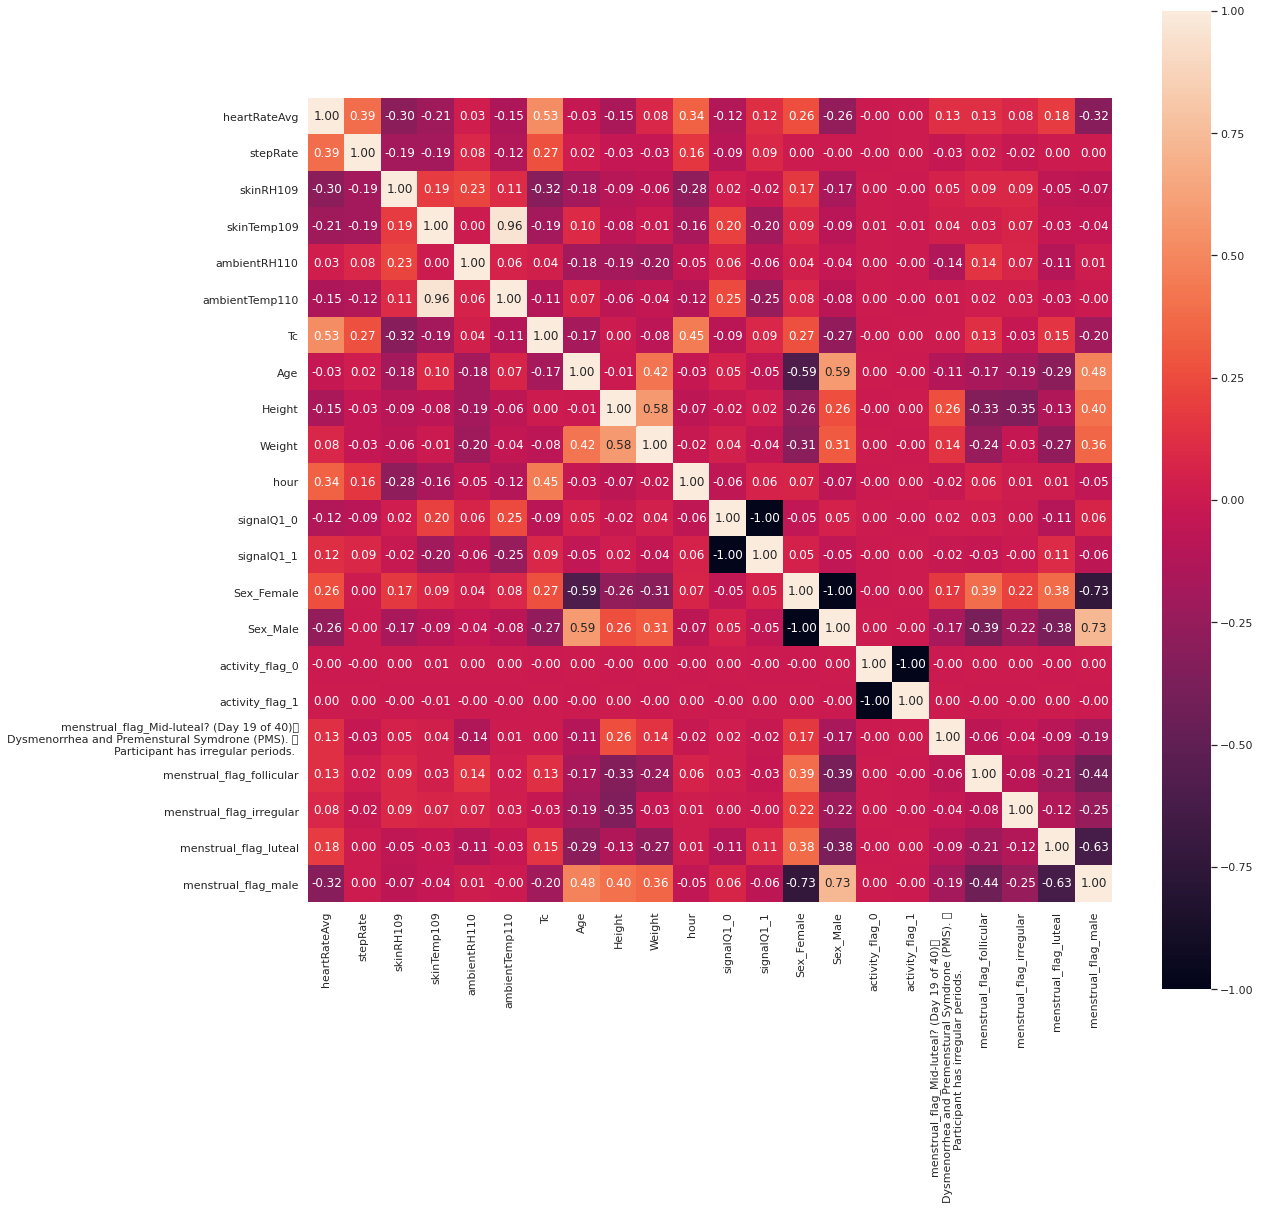

In [ ]:
col=final_df.columns
corr=final_df.corr()
plt.figure(figsize = (18,18))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=col, yticklabels=col)
plt.show();

# Checking for Multicollinearity

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Function to get top correlations 

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(final_df, 20))

Top Absolute Correlations
activity_flag_0            activity_flag_1              1.000000
Sex_Female                 Sex_Male                     1.000000
signalQ1_0                 signalQ1_1                   1.000000
skinTemp109                ambientTemp110               0.956662
Sex_Male                   menstrual_flag_male          0.729877
Sex_Female                 menstrual_flag_male          0.729877
menstrual_flag_luteal      menstrual_flag_male          0.625868
Age                        Sex_Female                   0.593108
                           Sex_Male                     0.593108
Height                     Weight                       0.580489
heartRateAvg               Tc                           0.527338
Age                        menstrual_flag_male          0.478988
Tc                         hour                         0.447313
menstrual_flag_follicular  menstrual_flag_male          0.442607
Age                        Weight                       0.418333

Skin temperature and Ambient Temperature are highly corelatted.
So, I have removed Ambient temperature.

In [24]:
final=final.drop(columns=['ambientTemp110'],axis=1)

#Checking Correlation with Core Temperature:

Heart rate avg has high corelation with Temperature.

Age is negatively correlated and menstrual phase luteal and follicular has notable postive correlation.

In [ ]:
final_df[final_df.columns[:]].corr()['Tc'][:]

heartRateAvg                                                                                                                          0.527338
stepRate                                                                                                                              0.271620
skinRH109                                                                                                                            -0.317028
skinTemp109                                                                                                                          -0.189277
ambientRH110                                                                                                                          0.035151
Tc                                                                                                                                    1.000000
Age                                                                                                                                  -0.174477

# Sampling:

The data set is having ~2.7 million records. I tried to run but the compiler got crashed each time. So, I have taken 100,000 samples to train my model.

In [ ]:
final_df=final.sample(50000)

X and Y Split

In [ ]:
y=final_df[['Tc']]
x=final_df.drop(['Tc'],axis=1)

Test-Train Split:

Train 70% = 70,000

Test 30% = 30,000

In [ ]:
# Train/Test Split 70/30
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Modelling

1. Polynomial Regression - Default Parameters¶

Default model - The default Polynomial Regression model is evaluated with 5 fold cross validation on train set. The model is then fit on the train data and predictions are performed on test data. RMSE and MAE using default model on test data are reported.


In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [ ]:

steps = [('poly',PolynomialFeatures()), ('linear',LinearRegression())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
def_rmse = mean_squared_error(y_test, y_pred_def)
def_rmse = np.sqrt(def_rmse)
def_MAE=mean_absolute_error(y_test, y_pred_def)
def_r2 = r2_score(y_test,y_pred_def)

print('Polynomial Regression (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("Polynomial Regression (default parameters) R2 score on test set: " + str(round(def_r2,1)))
print()
print("Polynomial Regression (default parameters) RMSE on test set: " + str(round(def_rmse,2)))
print()
print("Polynomial Regression (default parameters) MAE on test set: " + str(round(def_MAE,2)))

Polynomial Regression (default parameters) mean cross validated RMSE on train set: 0.25

Polynomial Regression (default parameters) R2 score on test set: 0.6

Polynomial Regression (default parameters) RMSE on test set: 0.25

Polynomial Regression (default parameters) MAE on test set: 0.19



Polynomial Regression - Hyperparameter Optimization

we optimize the parameters of the model using 5 cross validation. An extensive parameter search is performed using several grid searches. 'neg_root_mean_squared_error' is used as scoring function during grid search. The 'best estimator' model obtained after grid searches with 5 fold cross validation is finally used to perform predictions on the test set.


In [ ]:
from sklearn.model_selection import GridSearchCV

steps = [('poly',PolynomialFeatures()), ('linear',LinearRegression())]
pipeline = Pipeline(steps)

parameters = {'poly__degree':[2,3],'linear__normalize': [True, False]}
grid_poly = GridSearchCV(pipeline,param_grid=parameters,cv=5, scoring='neg_root_mean_squared_error')
grid_poly.fit(X_train,y_train)              
print('Best Parameters with grid search:') 
print(grid_poly.best_params_)  

poly_rmse = abs(grid_poly.best_score_)
best_std = grid_poly.cv_results_['std_test_score'][grid_poly.best_index_]
print('Mean cross validated RMSE with best estimator: '+ str(round(poly_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Best Parameters with grid search:
{'linear__normalize': False, 'poly__degree': 2}
Mean cross validated RMSE with best estimator: 0.25, Standard deviation: 0.0


In [ ]:
#predict using model with tuned hyperparameters
y_pred_tuned = grid_poly.predict(X_test)
poly_tuned_r2 = r2_score(y_test,y_pred_tuned)
poly_tuned_rmse = mean_squared_error(y_test, y_pred_tuned)
poly_tuned_rmse = np.sqrt(poly_tuned_rmse)
poly_tuned_MAE =mean_absolute_error(y_test, y_pred_tuned)
print('R2 score using tuned Polynomial Regression: ' + str(round(poly_tuned_r2,1)))
print()
print('RMSE using tuned Polynomial Regression on test set: ' + str(round(poly_tuned_rmse,2)))
print()
print('MAE using tuned Polynomial Regression on test set: ' + str(round(poly_tuned_MAE,2)))

R2 score using tuned Polynomial Regression: 0.6

RMSE using tuned Polynomial Regression on test set: 0.25

MAE using tuned Polynomial Regression on test set: 0.19


In [ ]:
#final summary
print('Summarizing: ')
print()
print("Polynomial Regression (default parameters) RMSE on test set: " + str(round(def_rmse,2)))
print()
print('Polynomial Regression (tuned parameters) RMSE on test set: ' + str(round(poly_tuned_rmse,2)))
print()
print("Polynomial Regression (default parameters) MAE on test set: " + str(round(def_MAE,2)))
print()
print('Polynomial Regression (tuned parameters) MAE on test set: ' + str(round(poly_tuned_MAE,2)))

Summarizing: 

Polynomial Regression (default parameters) RMSE on test set: 0.25

Polynomial Regression (tuned parameters) RMSE on test set: 0.25

Polynomial Regression (default parameters) MAE on test set: 0.19

Polynomial Regression (tuned parameters) MAE on test set: 0.19



2. Support Vector Machine - Default parameters

The default Support Vector Regressor model is evaluated with 5 fold cross validation on train set. The model is then fit on the entire train data and predictions are performed on test data. RMSE and MAE using default model on test data are reported.


In [ ]:
#evaluate svr with default parameters on test set
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

steps = [('SVR', SVR())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
svr_def_r2 = r2_score(y_test,y_pred_def)
svr_def_rmse = np.sqrt(mean_squared_error(y_test, y_pred_def))

print('SVR (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print('SVR (default parameters) R2 score on test set: ' + str(round(svr_def_r2,1)))
print()
print('SVR (default parameters) RMSE score on test set: ' + str(round(svr_def_rmse,2)))


SVR (default parameters) mean cross validated RMSE on train set: 0.29

SVR (default parameters) R2 score on test set: 0.5

SVR (default parameters) RMSE score on test set: 0.29


In [ ]:
svr_def_MAE = mean_absolute_error(y_test, y_pred_def)
print()
print('SVR (default parameters) MAE score on test set: ' + str(round(svr_def_MAE,2)))


SVR (default parameters) MAE score on test set: 0.19



3. XGBoost - Default parameters

The default XGBoost model is evaluated with 5 fold cross validation on train set. The model is then fit on the train data and predictions are performed on test data. RMSE and MAE using default model on test data is reported.


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

#build xgboost model
model = XGBRegressor(seed=123,objective="reg:linear",verbosity = 0)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(model,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions made on test set
xg_def_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xg_def_MAE= mean_absolute_error(y_test, y_pred)

print('XGBoost (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("XGBoost (default parameters) RMSE on test set: " + str(round(xg_def_rmse,2)))
print()
print("XGBoost (default parameters) MAE on test set: " + str(round(xg_def_MAE,2)))

XGBoost (default parameters) mean cross validated RMSE on train set: 0.23

XGBoost (default parameters) RMSE on test set: 0.24

XGBoost (default parameters) MAE on test set: 0.18


Hyperparameter Tuning:

Tuned model - we optimize the parameters of the model using 5 cross validation. An extensive parameter search is performed using several grid searches. 'neg_root_mean_squared_error' is used as scoring function during grid search. The 'best estimator' model obtained after grid searches with 5 fold cross validation is finally used to perform predictions on the test set. 

In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

steps = [('XGB',XGBRegressor(objective="reg:linear",verbosity = 0) )]
pipeline = Pipeline(steps)

#define hyperparameters to tune
parameters = {'XGB__colsample_bytree': [0.9,1.0],'XGB__subsample': [0.9,1.0],
                'XGB__max_depth': [10,11], 'XGB__eta':[0.05,0.1], 'XGB__min_child_weight':[2,4] }

#perform grid search using cross validation
grid1_xg = GridSearchCV(pipeline, param_grid=parameters, cv=5,scoring='neg_root_mean_squared_error')
grid1_xg.fit(X_train, y_train)
print('Best Parameters with grid1:') 
print(grid1_xg.best_params_)
print()
grid1_rmse = abs(grid1_xg.best_score_)
best_std = grid1_xg.cv_results_['std_test_score'][grid1_xg.best_index_]
print('Mean cross validated RMSE with best estimator grid1: '+ str(round(grid1_rmse,2)) + ', Standard deviation: ' + str(round(best_std,2)))

Best Parameters with grid1:
{'XGB__colsample_bytree': 0.9, 'XGB__eta': 0.05, 'XGB__max_depth': 11, 'XGB__min_child_weight': 2, 'XGB__subsample': 0.9}

Mean cross validated RMSE with best estimator grid1: 0.09, Standard deviation: 0.0


# Feature importance

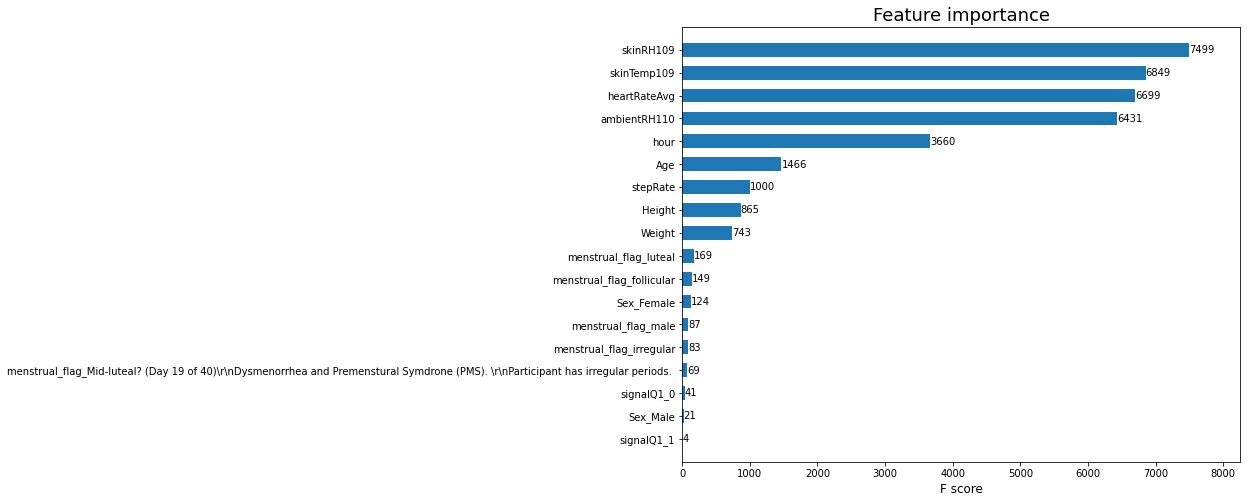

In [ ]:
#plot feature importances of best estimator
from xgboost import plot_importance
reg = grid1_xg.best_estimator_['XGB']
xg_model = reg.fit(X_train,y_train)
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xg_model,height=0.6,grid=False,ylabel='', ax=ax)
plt.title("Feature importance", fontsize=18)
plt.xlabel("F score", fontsize=12);
#The measures are based on the number of times a variable is selected for splitting

In [ ]:
final.columns

Index(['heartRateAvg', 'stepRate', 'skinRH109', 'skinTemp109', 'ambientRH110',
       'Tc', 'Age', 'Height', 'Weight', 'hour', 'signalQ1_0', 'signalQ1_1',
       'Sex_Female', 'Sex_Male', 'activity_flag_0', 'activity_flag_1',
       'menstrual_flag_Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods. ',
       'menstrual_flag_follicular', 'menstrual_flag_irregular',
       'menstrual_flag_luteal', 'menstrual_flag_male'],
      dtype='object')

In [25]:
final_df_1=final.drop(columns=['signalQ1_0', 'signalQ1_1',
       'Sex_Female', 'Sex_Male', 'activity_flag_0', 'activity_flag_1',
       'menstrual_flag_Mid-luteal? (Day 19 of 40)\r\nDysmenorrhea and Premenstural Symdrone (PMS). \r\nParticipant has irregular periods. ',
       'menstrual_flag_follicular', 'menstrual_flag_irregular',
       'menstrual_flag_luteal', 'menstrual_flag_male','Height', 'Weight'],axis=1)

In [26]:
final_df_1.columns

Index(['heartRateAvg', 'stepRate', 'skinRH109', 'skinTemp109', 'ambientRH110',
       'Tc', 'Age', 'hour'],
      dtype='object')

In [27]:
final_df_1=final_df_1.sample(50000)

In [28]:
y=final_df_1[['Tc']]
x=final_df_1.drop(['Tc'],axis=1)

In [ ]:
x.head()

,heartRateAvg,stepRate,skinRH109,skinTemp109,ambientRH110,Age,hour
1299718,44.14,0,64.270,34.8400,77.350,23,4
1168259,62.35,92,41.185,29.7050,55.730,23,21
2266762,69.77,104,29.995,28.7075,53.990,38,14
541221,63.71,0,35.154,33.7040,56.308,26,14
1650638,44.84,0,39.482,35.1100,67.126,24,6


In [29]:
# Train/Test Split 70/30
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [32]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

#build xgboost model
model = XGBRegressor(seed=123,objective="reg:linear",verbosity = 0)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(model,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate predictions made on test set
xg_def_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xg_def_MAE= mean_absolute_error(y_test, y_pred)

print('XGBoost (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("XGBoost (default parameters) RMSE on test set: " + str(round(xg_def_rmse,2)))
print()
print("XGBoost (default parameters) MAE on test set: " + str(round(xg_def_MAE,2)))

XGBoost (default parameters) mean cross validated RMSE on train set: 0.25

XGBoost (default parameters) RMSE on test set: 0.24

XGBoost (default parameters) MAE on test set: 0.18


In [35]:
steps = [('poly',PolynomialFeatures()), ('linear',LinearRegression())]
pipeline = Pipeline(steps)

# evaluate default model with 5 fold cross validation on train set
scores = cross_val_score(pipeline,X_train,y_train, cv=5, scoring='neg_root_mean_squared_error')
mean_score = abs(np.mean(scores))

#fit model on entire train set and predict on test set
pipeline.fit(X_train,y_train)
y_pred_def = pipeline.predict(X_test)

# evaluate predictions made on test set
def_rmse = mean_squared_error(y_test, y_pred_def)
def_rmse = np.sqrt(def_rmse)
def_MAE=mean_absolute_error(y_test, y_pred_def)
def_r2 = r2_score(y_test,y_pred_def)

print('Polynomial Regression (default parameters) mean cross validated RMSE on train set: ' + str(round(mean_score,2)))
print()
print("Polynomial Regression (default parameters) R2 score on test set: " + str(round(def_r2,1)))
print()
print("Polynomial Regression (default parameters) RMSE on test set: " + str(round(def_rmse,2)))
print()
print("Polynomial Regression (default parameters) MAE on test set: " + str(round(def_MAE,2)))

Polynomial Regression (default parameters) mean cross validated RMSE on train set: 0.3

Polynomial Regression (default parameters) R2 score on test set: 0.6

Polynomial Regression (default parameters) RMSE on test set: 0.3

Polynomial Regression (default parameters) MAE on test set: 0.23


In [36]:
import pickle
#filename = 'model.pkl'
#pickle.dump(model, open(filename, 'rb'))

pickle.dump(pipeline, open('model_1.pkl','wb'))

# Results:

• I have used Polynomial regression(default and Hyperparameter tuned), Support vector Machines and XG Boost. (* I tried hyperparameter tunning for SVM and 
XG Boost, it took more than 2 hours and it was still running).

• Evaluation metrics: Root mean Square error and Mean Absolute error.

• Polynomial Default: RMSE-0.25, MAE-0.19

• Polynomial(tuned): RMSE-0.25, MAE-0.19 

• SVM: RMSE-0.29, MAE-0.19 

• XG Boost: RMSE-0.22, MAE-0.17

• Important Feature: 
  Ambient RH110,heart rate avg, skinRh109 and skintemp109 are highly important.

• Best Model: XG boost with RMSE-0.22, MAE-0.17

# Future works:

• There is a scope of hyperparameter tuning (SVM and XG Boost) for this approach which can possibly improve the results. 

• Try to implemenmt other algorithms like Naive bayes, decision tree and advanced algorithms such as Neural Networks.

• I have used 100,000 data points out of 2.7 million records. I'll use as much data as possible. More the data better the model.
